In [1]:
import ast
import json
import os
import shutil

import albumentations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom as dicom
import tensorflow as tf
import tensorflow_addons as tfa
import torch
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from tqdm import tqdm

from src.generator import Generator, GetModel

In [2]:
df = pd.read_csv("/app/_data/train.csv")
list_wrong = df[(df["class"] != "negative") & (df["label"] == "none 1 0 0 1 1")][
    "id_image"
].tolist()
df = df.query("id_image not in @list_wrong").reset_index(drop=True)

In [3]:
with open("/app/_data/base_config.json", "r") as f:
    base_config = json.load(f)
base_config["EFFB7"]["BATCH_SIZE"] = 4
base_config["EFFB7"]["SEED"]

42

In [4]:
labels = pd.read_csv("/app/_data/additional_dataset/labels_full.csv")
labels = labels.query("Target==0").reset_index(drop=True)
labels["image"] = labels["patientId"] + ".dcm"
labels["class"] = "negative"
labels = labels[["image", "class", "modality", "PatientSex", "BodyPartExamined"]]

# val only from df

In [5]:
skf = StratifiedKFold(n_splits=5, random_state=1488, shuffle=True)
train_ids = []
val_ids = []
for train_index, valid_index in skf.split(df, df["class"]):
    train_ids.append(train_index)
    val_ids.append(valid_index)

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
Warning! Model path already exists.
Epoch 1/50
652/652 [==============================] - 819s 1s/step - loss: 0.6619 - acc: 0.6505 - recall: 0.6505 - precision: 0.6505 - f1_score: 0.6489 - val_loss: 1.0364 - val_acc: 0.4475 - val_recall: 0.4475 - val_precision: 0.4475 - val_f1_score: 0.4112

Epoch 00001: val_acc improved from -inf to 0.44750, saving model to /app/_data/models/EffB7_2class_1/EffB7_2cl_0.h5
Epoch 2/50
652/652 [==============================] - 799s 1s/step - loss: 0.5349 - acc: 0.7543 - recall: 0.7543 - precision: 0.7543 - f1_score: 0.7533 - val_loss: 0.6504 - val_acc: 0.6825 - val_r

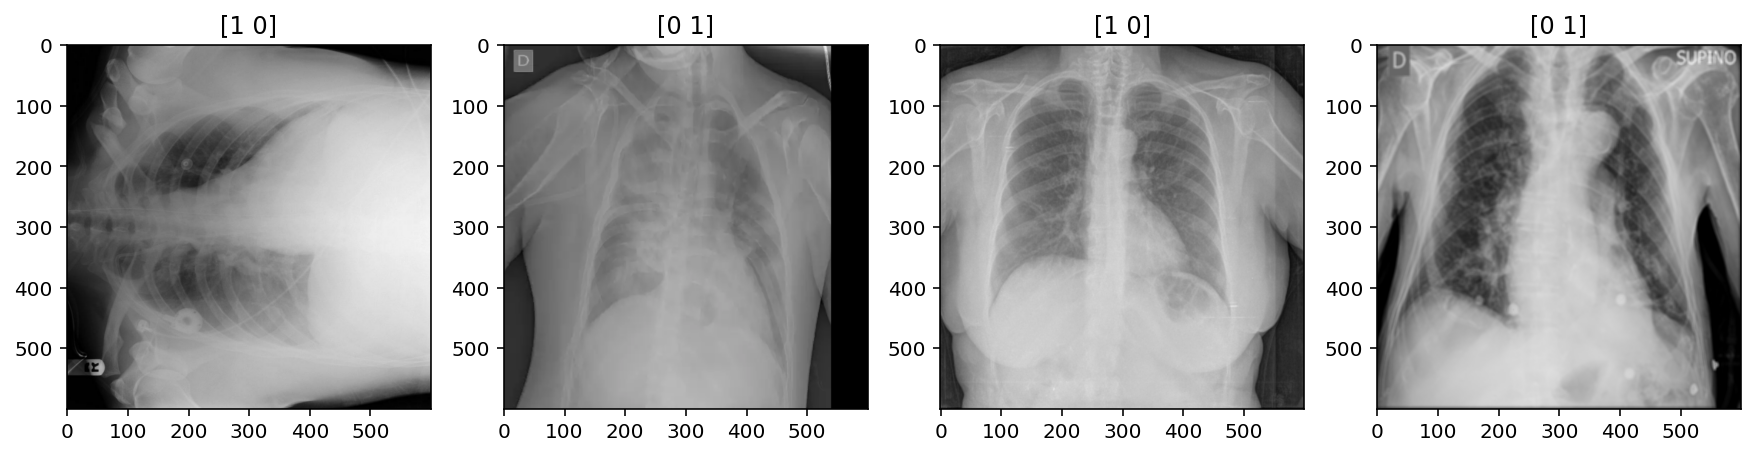

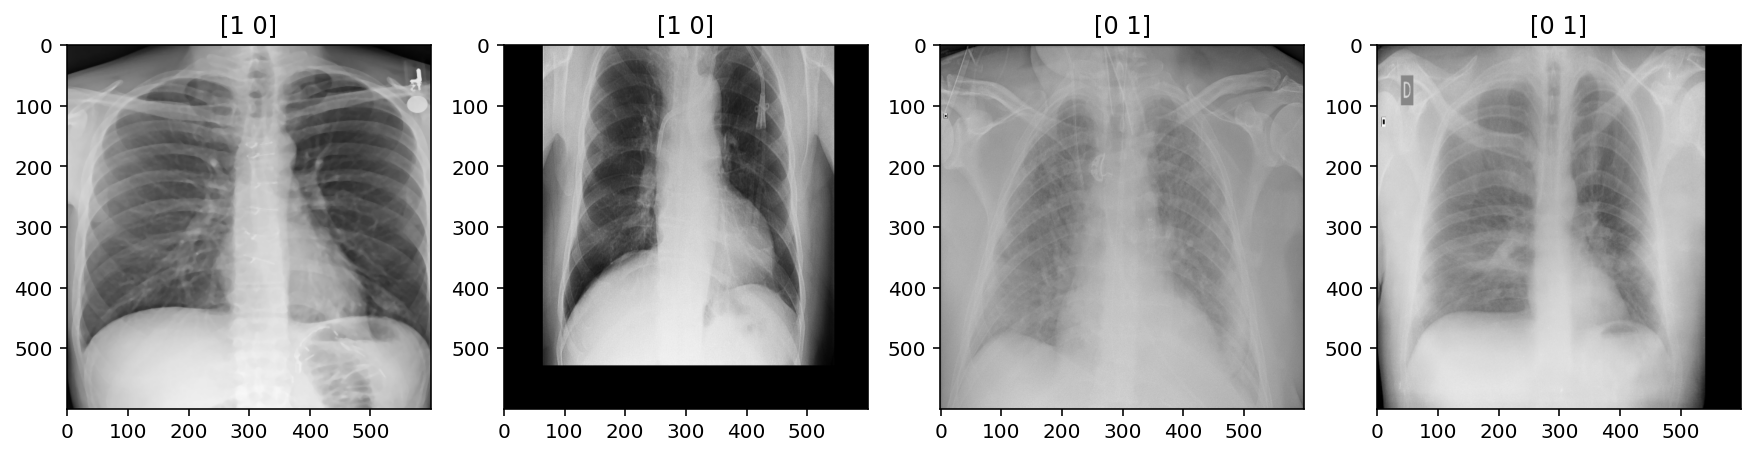

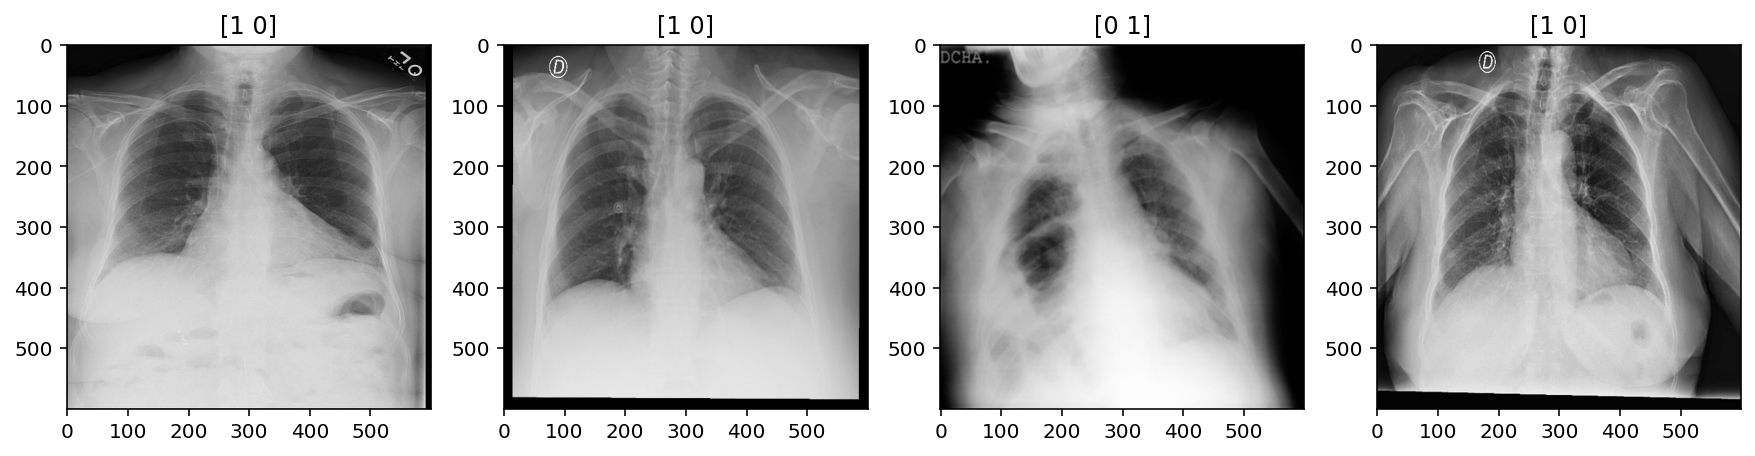

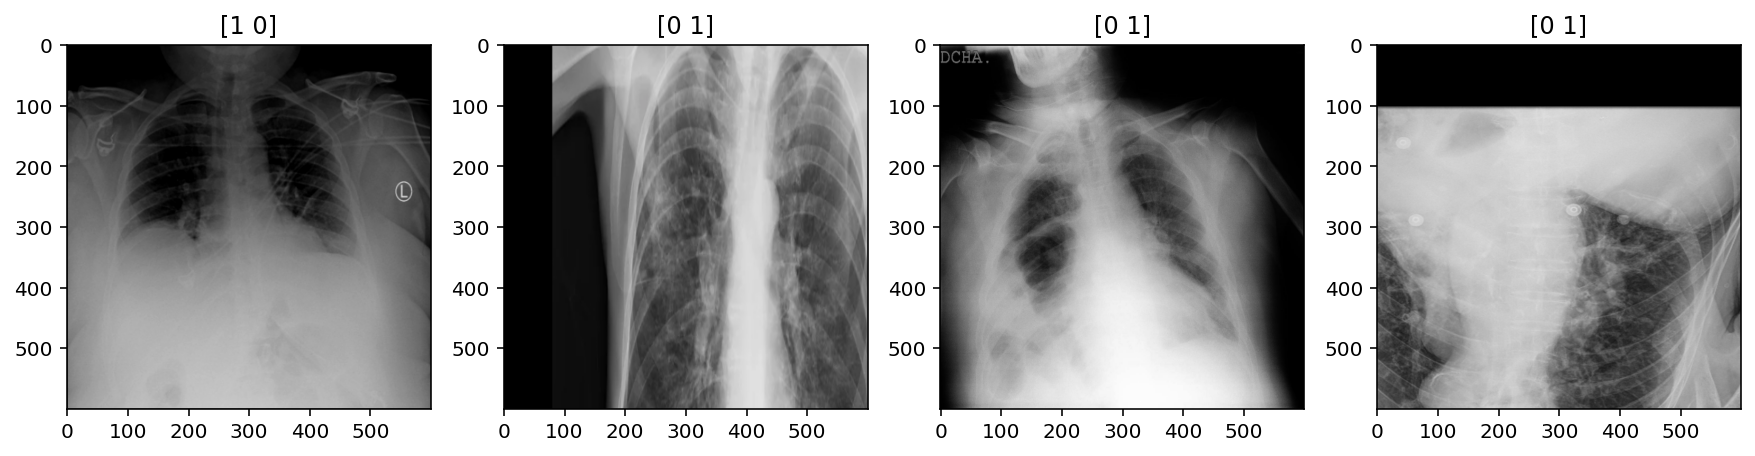

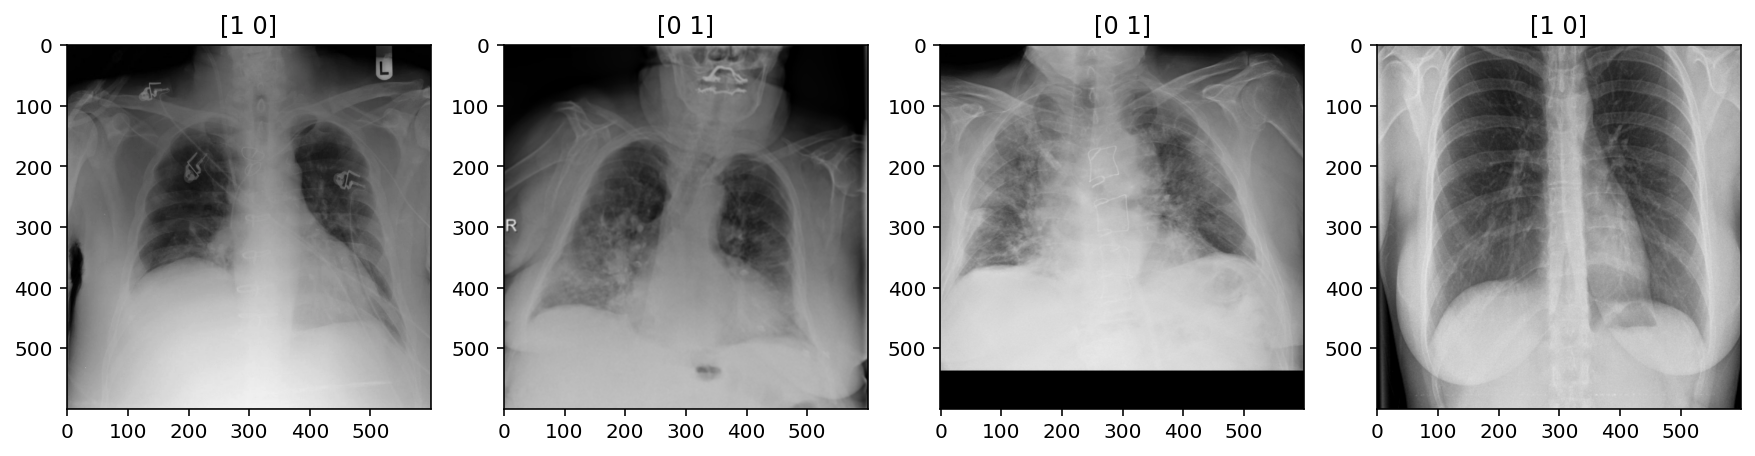

In [6]:
for n in range(5):
    val = df.loc[val_ids[n]].sample(frac=1, random_state=base_config["EFFB7"]["SEED"])
    train = pd.concat(
        [
            df.loc[
                train_ids[n],
                ["image", "class", "modality", "PatientSex", "BodyPartExamined"],
            ],
            labels.sample(3000),
        ],
        ignore_index=True,
        axis=0,
    ).sample(frac=1, random_state=base_config["EFFB7"]["SEED"])

    tf.config.list_physical_devices("GPU")

    gen_train = Generator(
        df=train,
        batch_size=base_config["EFFB7"]["BATCH_SIZE"],
        seed=base_config["EFFB7"]["SEED"],
        img_size=base_config["EFFB7"]["IMG_SIZE"],
        prepared_img_path="/app/_data/train_jpg_600/",
        shuffle=True,
        augment=False,
        hard_augment=True,
        n_inputs=2,
        n_classes=2,
    )
    gen_valid = Generator(
        df=val,
        batch_size=base_config["EFFB7"]["BATCH_SIZE"],
        seed=base_config["EFFB7"]["SEED"],
        img_size=base_config["EFFB7"]["IMG_SIZE"],
        prepared_img_path="/app/_data/train_jpg_600/",
        shuffle=False,
        augment=False,
        hard_augment=False,
        n_inputs=2,
        n_classes=2,
    )

    train_sample = gen_train.__getitem__(10)

    plt.figure(figsize=(15, 5))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(train_sample[1][i])
        plt.imshow(train_sample[0]["img"][i])

    model = GetModel(
        model_name="EFFB7",
        n_inputs=2,
        lr=0.0007,
        activation_func="softmax",
        weights=None,
        n_classes=2,
    ).get_model()
    policy = keras.mixed_precision.experimental.Policy("mixed_float16")
    keras.mixed_precision.experimental.set_policy(policy)

    callbacks = GetModel("EFFB7", n_classes=1).make_callback(
        model_path="/app/_data/models/EffB7_2class_1/",
        model_name="EffB7_2cl_" + str(n) + ".h5",
        tensorboard_path="/app/.tensorboard/EffB7_2cl11_" + str(n),
        patience_ES=10,
        patience_RLR=3,
        factor_LR=0.8,
        metric_for_monitor="val_acc",
        metric_mode="max",
    )

    history = model.fit(
        gen_train,
        validation_data=gen_valid,
        epochs=50,
        steps_per_epoch=train.shape[0] // base_config["EFFB7"]["BATCH_SIZE"] // 3,
        validation_steps=val.shape[0] // base_config["EFFB7"]["BATCH_SIZE"] // 3,
        verbose=1,
        workers=20,
        max_queue_size=500,
        callbacks=callbacks,
    )
    keras.backend.clear_session()